In [1]:
# Import libraries that will be needed for the lab

import xgboost as xgb
import numpy as np
from collections import OrderedDict
import gc
from glob import glob
import os
import pandas as pd
from copy import copy
from time import time
from sklearn.metrics import (roc_auc_score,
                             confusion_matrix,accuracy_score,
                             classification_report,roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from timeit import default_timer
import matplotlib.pyplot as plt
import pickle

# Set the seed for numpy
seed = 1024
np.random.seed(seed)

# Display all columns of Pandas' dataframes by default
pd.set_option('display.max_columns', None)

In [4]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]

df =  pd.read_parquet('../data/interim/kddcup.parquet',)

# Display the first few rows of the dataset
df.head(5)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [13]:
pd.DataFrame(df['protocol_type'].value_counts())

,count
protocol_type,
icmp,2833545
tcp,1870598
udp,194288


In [14]:
pd.DataFrame(df['service'].value_counts())

,count
service,
ecr_i,2811660
private,1100831
http,623091
smtp,96554
other,72653
...,...
tftp_u,3
harvest,2
aol,2


In [5]:
df['label'] = df['label'].apply(lambda x: x.split('.')[0])
pd.DataFrame(df['label'].value_counts())

,count
label,
smurf,2807886
neptune,1072017
normal,972781
satan,15892
ipsweep,12481
portsweep,10413
nmap,2316
back,2203
warezclient,1020


In [6]:
# define a label to convert label values to integers
le = LabelEncoder()
le.fit(df.label)
print(le.classes_)

['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster']


In [10]:
df['label'][0].split('.')[0]

'normal'

## Data Processing

### One-hot Encode the Categorical Data

Here, we use 7 categorical features: protocol type, service, flag, land, logged_in, is_host_login, is_guest_login.

In [7]:
# capture the categorical variables and one-hot encode them
cat_vars = ['protocol_type', 'service', 'flag', 'land', 'logged_in','is_host_login', 'is_guest_login']

# find unique labels for each category
cat_data = pd.get_dummies(df[cat_vars])

# check that the categorical variables were created correctly
cat_data.head()

,land,logged_in,is_host_login,is_guest_login,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,0,1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
2,0,1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,0,1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,0,1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [8]:
numeric_vars = list(set(df.columns.values.tolist()) - set(cat_vars))
numeric_vars.remove('label')
numeric_data = df[numeric_vars].copy()

# check that the numeric data has been captured accurately
numeric_data.head()

,su_attempted,root_shell,num_compromised,dst_bytes,wrong_fragment,num_outbound_cmds,dst_host_serror_rate,hot,num_shells,dst_host_rerror_rate,srv_count,num_root,urgent,dst_host_count,dst_host_same_srv_rate,serror_rate,diff_srv_rate,same_srv_rate,count,dst_host_srv_diff_host_rate,dst_host_srv_rerror_rate,srv_rerror_rate,dst_host_diff_srv_rate,rerror_rate,src_bytes,duration,dst_host_srv_count,num_access_files,dst_host_srv_serror_rate,srv_diff_host_rate,num_failed_logins,num_file_creations,dst_host_same_src_port_rate,srv_serror_rate
0,0,0,0,45076,0,0,0.0,0,0,0.0,1,0,0,0,0.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,215,0,0,0,0.0,0.0,0,0,0.00,0.0
1,0,0,0,4528,0,0,0.0,0,0,0.0,2,0,0,1,1.0,0.0,0.0,1.0,2,0.0,0.0,0.0,0.0,0.0,162,0,1,0,0.0,0.0,0,0,1.00,0.0
2,0,0,0,1228,0,0,0.0,0,0,0.0,1,0,0,2,1.0,0.0,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,236,0,2,0,0.0,0.0,0,0,0.50,0.0
3,0,0,0,2032,0,0,0.0,0,0,0.0,2,0,0,3,1.0,0.0,0.0,1.0,2,0.0,0.0,0.0,0.0,0.0,233,0,3,0,0.0,0.0,0,0,0.33,0.0
4,0,0,0,486,0,0,0.0,0,0,0.0,3,0,0,4,1.0,0.0,0.0,1.0,3,0.0,0.0,0.0,0.0,0.0,239,0,4,0,0.0,0.0,0,0,0.25,0.0


In [9]:
# concat numeric and the encoded categorical variables
numeric_cat_data = pd.concat([numeric_data, cat_data], axis=1)

# here we do a quick sanity check that the data has been concatenated correctly by checking the dimension of the vectors
print(cat_data.shape)
print(numeric_data.shape)
print(numeric_cat_data.shape)

(4898431, 88)
(4898431, 34)
(4898431, 122)


In [10]:
# capture the labels
labels = df['label'].copy()

# convert labels to integers
integer_labels = le.transform(labels)

# split data into test and train
x_train, x_test, y_train, y_test = train_test_split(numeric_cat_data,
                                                    integer_labels,
                                                    test_size=.25, 
                                                    random_state=42)

In [11]:
# check that the dimensions of our train and test sets are okay
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3673823, 122)
(3673823,)
(1224608, 122)
(1224608,)


In [13]:

# save the datasets for later use
preprocessed_data = {
    'x_train':x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test,
    'le':le
}

# pickle the preprocessed_data
path = '../data/interim/preprocessed_data_full.pkl'
out = open(path, 'wb')
pickle.dump(preprocessed_data, out, protocol=pickle.HIGHEST_PROTOCOL)
out.close()

## Training a Binary Classifier

In [21]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 'normal')[0][0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

binary_y_train = convert_label_to_binary(le, y_train)
binary_y_test = convert_label_to_binary(le, y_test)

# check how many anomalies are in our labels
print('Number of anomalies in y_train: ', binary_y_train.sum())
print('Number of anomalies in y_test:  ', binary_y_test.sum())

Number of anomalies in y_train:  2944214
Number of anomalies in y_test:   981436


## Hyperparameter Tuning

In [22]:
params = {
    'num_rounds':        10,
    'max_depth':         8,
    'max_leaves':        2**8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'objective':         'binary:logistic',
    'verbose':           True
}

In [23]:
x_train.head()

,dst_host_count,srv_serror_rate,dst_host_srv_rerror_rate,srv_diff_host_rate,count,urgent,duration,dst_host_same_srv_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,wrong_fragment,src_bytes,srv_rerror_rate,dst_host_srv_diff_host_rate,diff_srv_rate,num_compromised,dst_host_srv_count,dst_host_same_src_port_rate,same_srv_rate,dst_host_serror_rate,serror_rate,hot,num_shells,dst_host_diff_srv_rate,srv_count,num_access_files,root_shell,num_root,rerror_rate,num_file_creations,dst_bytes,num_outbound_cmds,su_attempted,num_failed_logins,land,logged_in,is_host_login,is_guest_login,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
3316061,255,0.0,0.0,0.00,511,0,0,1.0,0.0,0.0,0,1032,0.0,0.0,0.0,0,255,1.0,1.0,0.0,0.0,0,0,0.0,511,0,0,0,0.0,0,0,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
239340,255,0.0,0.0,0.07,27,0,0,1.0,0.0,0.0,0,199,0.0,0.0,0.0,0,255,0.0,1.0,0.0,0.0,0,0,0.0,28,0,0,0,0.0,0,462,0,0,0,0,1,0,0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4219707,255,0.0,0.0,0.00,511,0,0,1.0,0.0,0.0,0,520,0.0,0.0,0.0,0,255,1.0,1.0,0.0,0.0,0,0,0.0,511,0,0,0,0.0,0,0,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3212920,255,0.0,0.0,0.00,511,0,0,1.0,0.0,0.0,0,1032,0.0,0.0,0.0,0,255,1.0,1.0,0.0,0.0,0,0,0.0,511,0,0,0,0.0,0,0,0,0,0,0,0,0,0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [33]:
binary_y_train[:5]

array([1, 0, 1, 1, 0])

In [24]:
y_train[0:100]

array([18, 11, 18, 18, 11, 18,  9, 18,  9, 11, 11, 18, 18, 11, 18,  9, 18,
       11, 18, 18, 18,  9, 18, 18, 11, 18, 18,  9, 18, 11, 18,  9, 18, 11,
        9, 11,  9, 18, 18, 18, 18, 18, 18, 18, 11, 18,  9, 18,  9, 18, 18,
       11, 11, 18, 18,  9, 18, 18, 18,  9, 18, 11, 18,  9, 18, 18,  9,  9,
       11, 18, 18,  9, 11, 18, 11, 11, 11, 11, 18, 18,  9, 18, 18, 11, 11,
       11, 11, 18, 11, 11, 18, 11,  9, 18,  9, 18, 18, 18,  9, 18])

In [25]:
%%time 

dtrain = xgb.DMatrix(x_train, label=binary_y_train)
dtest = xgb.DMatrix(x_test, label=binary_y_test)
evals = [(dtest, 'test',), (dtrain, 'train')]

CPU times: user 8.95 s, sys: 5.19 s, total: 14.1 s
Wall time: 6.16 s


In [26]:
num_rounds = params['num_rounds']

In [27]:
model = xgb.train(params, dtrain, num_rounds, evals=evals)

/Users/daniel/mlops/network_anomaly/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:27:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "num_rounds", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	test-logloss:0.39567	train-logloss:0.39569
[1]	test-logloss:0.33129	train-logloss:0.33131
[2]	test-logloss:0.28412	train-logloss:0.28414
[3]	test-logloss:0.24687	train-logloss:0.24688
[4]	test-logloss:0.21640	train-logloss:0.21640
[5]	test-logloss:0.19080	train-logloss:0.19079
[6]	test-logloss:0.16905	train-logloss:0.16904
[7]	test-logloss:0.15029	train-logloss:0.15028
[8]	test-logloss:0.13386	train-logloss:0.13384
[9]	test-logloss:0.11951	train-logloss:0.11948


In [28]:
threshold = .5
true_labels = binary_y_test.astype(int)
true_labels.sum()

981436

In [29]:
# make predictions on the test set using our trained model
preds = model.predict(dtest)
print(preds)

[0.2834069 0.9364738 0.2834069 ... 0.2834069 0.9364738 0.9364738]


In [30]:
pred_labels = (preds > threshold).astype(int)
print(pred_labels)

[0 1 0 ... 0 1 1]


In [31]:
pred_labels.sum()

981303

In [34]:
# compute the auc
auc = roc_auc_score(true_labels, preds)
print(auc)

0.9999163640020805


In [35]:
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Accuracy: 0.999605588073898


Confusion Matrix :


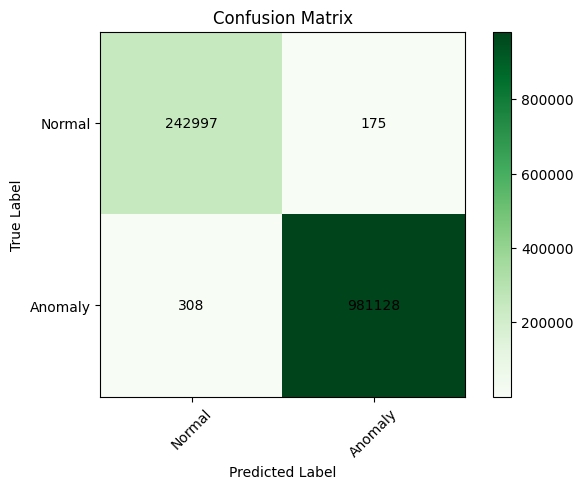

In [36]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

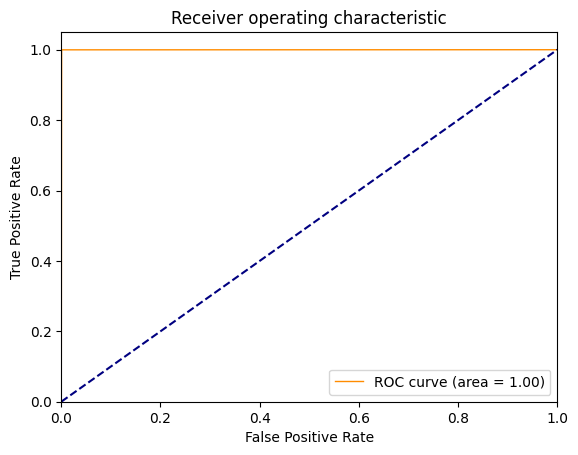

In [37]:
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

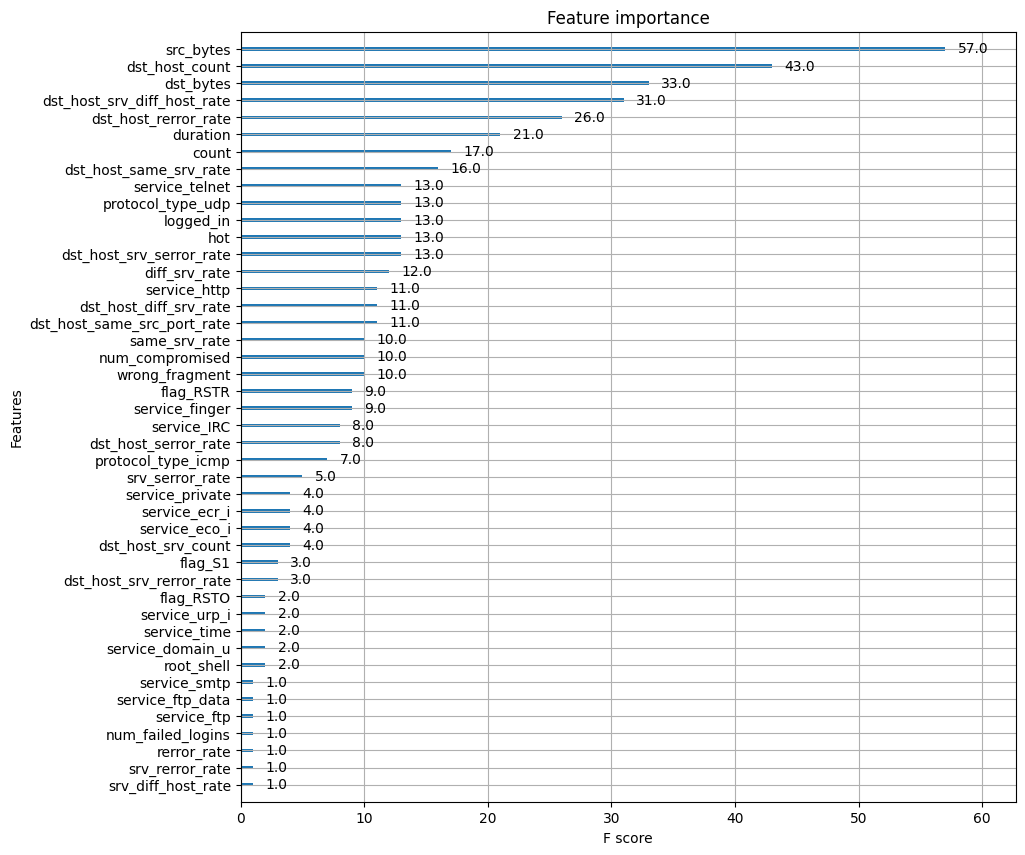

In [38]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)

In [39]:
def reduce_anomalies(df, pct_anomalies=.01):
    labels = df['label'].copy()
    is_anomaly = labels != 'normal'
    num_normal = np.sum(~is_anomaly)
    num_anomalies = int(pct_anomalies * num_normal)
    all_anomalies = labels[labels != 'normal']
    anomalies_to_keep = np.random.choice(all_anomalies.index, size=num_anomalies, replace=False)
    anomalous_data = df.iloc[anomalies_to_keep].copy()
    normal_data = df[~is_anomaly].copy()
    new_df = pd.concat([normal_data, anomalous_data], axis=0)
    return new_df

df = reduce_anomalies(df)

In [40]:
pd.DataFrame(df['label'].value_counts())

,count
label,
normal,972781
smurf,6976
neptune,2642
satan,45
portsweep,26
ipsweep,20
back,6
teardrop,6
nmap,3
